In [1]:
# import libraries
from pprint import pprint
import importlib
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
import matplotlib.animation as animation
from datetime import timedelta
import geopandas as gpd
import matplotlib.animation as animation
from PIL import Image
import io
from datetime import datetime
from owid import catalog
import numpy as np

# my function
import plot_data as pl
import transform_data as td
import statistical_analysis as sa
# import machine_learning_model as mlm

# Variables
cat = catalog.find(namespace="covid")
tb_country_cases_deaths = cat.iloc[1].load()  
tb_country_vac = cat.iloc[41].load() 
world = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

In [ ]:
# Transform data
# --------------------------------
importlib.reload(td)
importlib.reload(pl)

# proces relevant data
df_cd, df_vac = td.process_covid_data(tb_country_cases_deaths, tb_country_vac)

# Plot vaccination data.
country = 'Chile'
pl.plot_country_cd(country, df_cd)
pl.plot_country_vac(country, df_vac)

In [ ]:
# Correlations
importlib.reload(td)
importlib.reload(pl)
importlib.reload(sa)

df_cases_corr = sa.get_country_correlation(df_cd, 'new_cases')


In [49]:
top_10_corr = df_cases_corr['Mexico'].nlargest(11)[1:]  # Exclude Australia itself
print(top_10_corr)


country
United States         0.829435
Belize                0.751625
Dominican Republic    0.748697
Kazakhstan            0.738756
Italy                 0.720467
Lebanon               0.715219
Tunisia               0.712870
Morocco               0.709074
Israel                0.706416
Albania               0.706363
Name: Mexico, dtype: float64


In [348]:
importlib.reload(sa)
base_country = 'Brazil'
south_american_countries = [
    "Argentina", "Bolivia", "Brazil", "Chile", "Colombia",  
    "Uruguay", "Germany", "Indonesia"
]

short_list = ['Argentina', 'Bolivia', 'Brazil', 'Chile']
lag_max = 90

lagged_corr = sa.get_lagged_cases_correlation(df_cd, base_country, south_american_countries, lag_max)

In [349]:
importlib.reload(sa)
lag_max = 90

# Get the maximum correlations and the lag for each country
max_corr_data = sa.get_max_corr_list(df_cd, south_american_countries, lag_max)


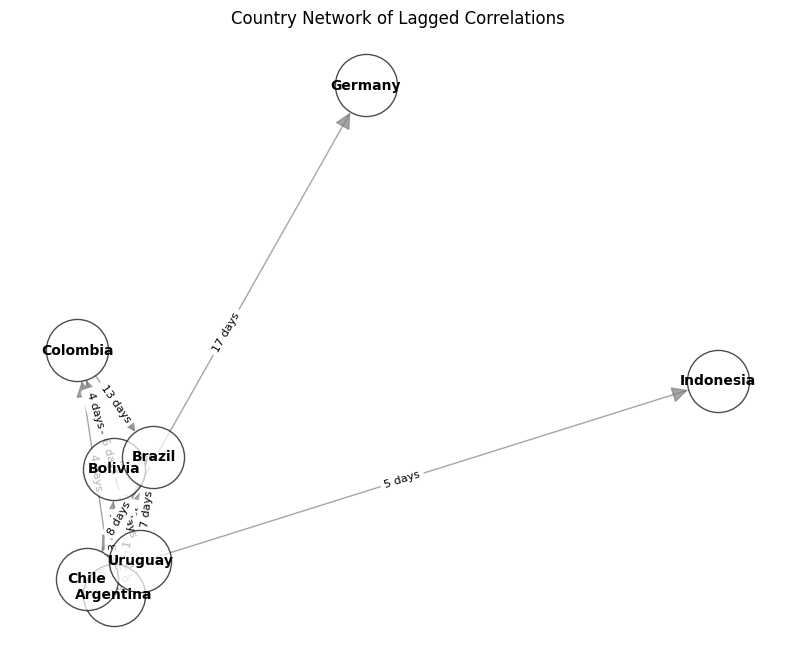

In [362]:
importlib.reload(sa)

# Plot the network
max_lag_disp = 17 # maximum days of the lag for the line to still be displayed.
sa.plot_network(max_corr_data, south_american_countries, max_lag_disp)